# Chapter 7 - The ARIMA Model


## Listing 7-1. Importing the data


In [1]:
import statsmodels.api as sm

data = sm.datasets.co2.load_pandas()
data = data.data
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


## Listing 7-2. Importing the data


<Axes: ylabel='CO2 level'>

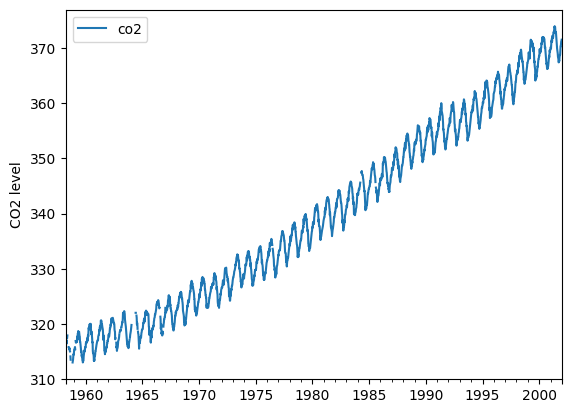

In [2]:
data.plot(ylabel="CO2 level")

## Listing 7-3. ACF and PACF plots


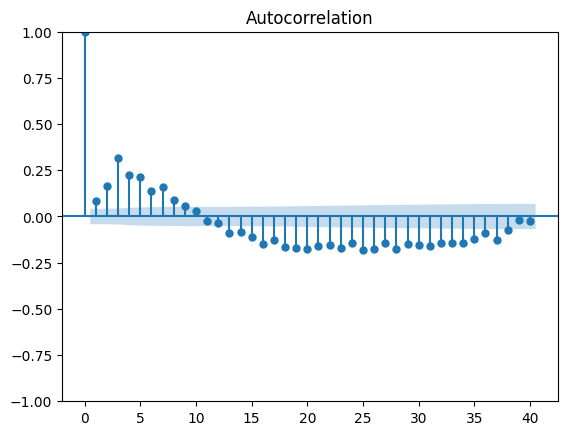

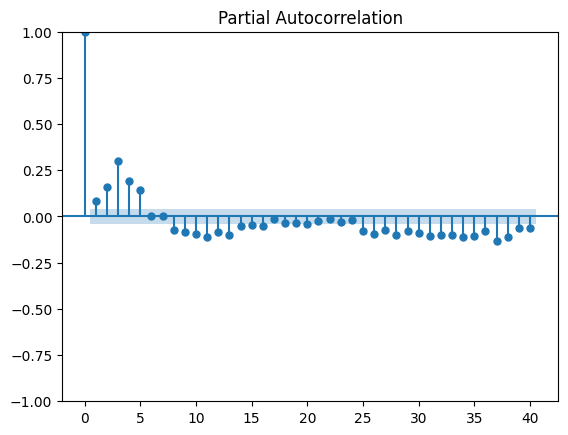

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_ = plot_acf(data.diff().dropna(), lags=40)
_ = plot_pacf(data.diff().dropna(), lags=40)

## Listing 7-4. ACF and PACF plots with more lags


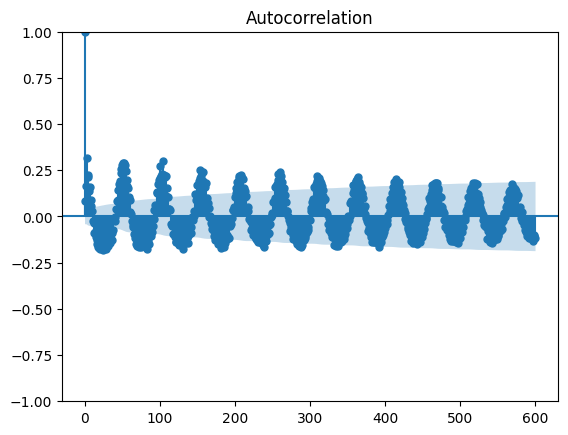

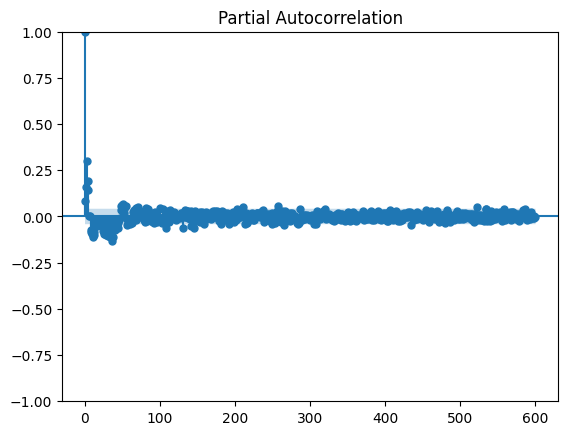

In [5]:
_ = plot_acf(data.diff().dropna(), lags=600)
_ = plot_pacf(data.diff().dropna(), lags=600)

## Listing 7-5. Hyperparameter tuning


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import mlflow

exp = mlflow.create_experiment(name="arima")
print("exp = ", exp)

data_array = data[["co2"]].values
avg_errors = []

for p in range(6):
    for q in range(6):
        for i in range(3):
            run = mlflow.start_run(experiment_id=exp)
            print("run = ", run.info.run_id)

            mlflow.log_param("p", p)
            mlflow.log_param("q", q)
            mlflow.log_param("i", i)

            errors = []

            tscv = TimeSeriesSplit(test_size=10)

            for train_index, test_index in tscv.split(data_array):
                X_train, X_test = data_array[train_index], data_array[test_index]
                X_test_orig = X_test

                fcst = []
                for step in range(10):
                    try:
                        mod = ARIMA(X_train, order=(p, i, q))
                        res = mod.fit()
                        fcst.append(res.forecast(steps=1))
                    except Exception:
                        print("errorred")
                        fcst.append(np.array([9999999.0]))

                    X_train = np.concatenate((X_train, X_test[0:1, :]))
                    X_test = X_test[1:]

                errors.append(r2_score(X_test_orig, fcst))

            mean_err = np.mean(errors)

            pq_result = [p, i, q, mean_err]

            print(pq_result)
            avg_errors.append(pq_result)

            mlflow.log_metric("10step-r2-score-crossvalidated", mean_err)
            mlflow.end_run()

avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ["p", "i", "q", "error"]
avg_errors.sort_values("error", ascending=False)

## Listing 7-6. Plot the final result


c:\Users\bodau\Documents\Dev\Advanced-Forecasting-with-Python-2nd-ed\Advanced-Forecasting-with-Python-2nd-ed\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bodau\Documents\Dev\Advanced-Forecasting-with-Python-2nd-ed\Advanced-Forecasting-with-Python-2nd-ed\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bodau\Documents\Dev\Advanced-Forecasting-with-Python-2nd-ed\Advanced-Forecasting-with-Python-2nd-ed\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bodau\Documents\Dev\Advanced-Forecasting-with-

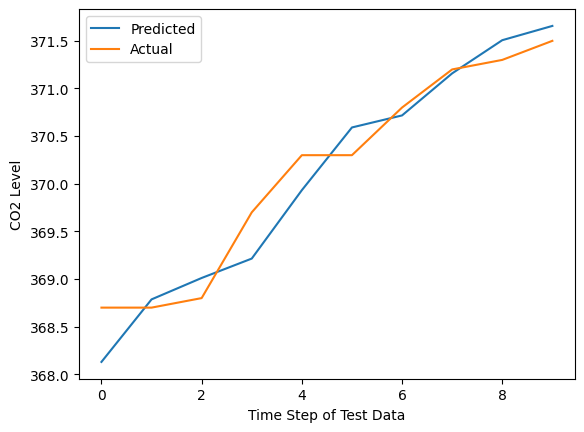

In [9]:
import matplotlib.pyplot as plt

X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test

fcst = []
for step in range(10):
    mod = ARIMA(X_train, order=(4, 1, 4))
    res = mod.fit()
    fcst.append(res.forecast(steps=1))
    X_train = np.concatenate((X_train, X_test[0:1, :]))
    X_test = X_test[1:]

plt.plot(fcst)
plt.plot(X_test_orig)
plt.legend(["Predicted", "Actual"])
plt.ylabel("CO2 Level")
plt.xlabel("Time Step of Test Data")
plt.show()